# Sampling and the law of large numbers

We saw how probability distributions can be used in Monte Carlo simulation. In this notebook, we see how they can be used to sample data: Sampling is a fundamental process in the collection of data. Sampling is important because we can almost never look at the whole population. Some key points to keep in mind about sampling are:

- An understanding of sampling is essential to ensure that analyses performed are representative of the entire population. 
- You will use **inference** on the sample to say something about the population.
- You will need estimates of variances on the sample calculations to say something about the population.

Let's look at some examples of sampling.

| use case | sample | population |
|---|---|---|
| A/B Testing | users we show either web sites A or B | all possible users, past present and future |
| World Cup | 32 teams which qualify in one season | all national teams in past, present and future years |
| average height of data science students | students in UW data science program | all students taking data science classes world wide |

Notice, that in several cases it is not only impractical, but impossible to collect data from the entire population. Hence, we must work with correctly collected samples. 

At the conclusion of this lesson, you should be able to apply a number of commonly used sampling strategies: 

- simple random sample
- Bernoulli sampling
- stratified sampling
- cluster sampling
- systematic sampling

In [1]:
import numpy.random as nr
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc = {'figure.figsize': (10, 8)})

Let's first generate a dataset that we will use to draw samples from later. The data has a single numeric variable generated from a standard normal distribution and a grouping variable called `group` with 4 groups and another grouping variable called `cluster` which we use to illustrate the difference between various sampling strategies.

In [2]:
nr.seed(345)
nrows = 200

data = pd.DataFrame({"var": nr.normal(size = nrows), 
                     "group": nr.choice(range(4), size = nrows, p = [0.1,0.3,0.4,0.2]),
                     "cluster": nr.choice(range(10), size = nrows)})
data.head()

,var,group,cluster
0,1.469248,1,0
1,-1.150144,1,7
2,2.519226,0,9
3,-0.082478,1,6
4,-0.033601,1,2


Here's a breakdown showing the average for `var` and frequencies and relative frequencies in each group.

In [3]:
def mean_count(df, by = 'group'):
    res = df.groupby(by).agg({'var':['mean', 'count']})
    res.loc[:, ('var', 'pct')] = df[by].value_counts(normalize = True)
    return res

mean_count(data)

var            
           mean count   pct
group                      
0     -0.016270    24  0.12
1      0.033306    62  0.31
2      0.051564    68  0.34
3     -0.170043    46  0.23

In the remainder of the notebook, we may occasionally refer to this data as the **population**.

## Simple random sample

A **simple random sample (SRS)** is probably the most common way to sample data. The sample size is fixed and every  data point has the same probability of ending up in the sample. There are many ways to create a simple random sample from data.

In [11]:
sample_srs = data.sample(n = 10)
sample_srs

,var,group,cluster
162,0.420006,2,3
6,-0.412092,3,3
105,0.608862,2,6
185,0.585429,1,7
30,-0.538969,0,5
65,-0.325200,2,6
114,-0.571162,0,5
163,-1.028874,2,4
183,2.168465,1,1
82,1.385794,0,1


In [8]:
sample_srs = data.sample(frac = 0.05)
sample_srs

,var,group,cluster
92,-1.743222,0,8
35,0.175477,2,7
105,0.608862,2,6
119,-1.582794,1,5
192,-0.764813,3,2
157,0.708641,3,2
6,-0.412092,3,3
91,2.118946,2,5
67,-0.043446,2,2
87,0.702183,2,8


## Bernoulli sampling

A Bernoulli sample is a sample where all population members have equal an chance of being selected. A Bernoulli sample is very similar to SRS, with the distinction that in an SRS the sample size is usually fixed but in a Bernoulli sample it can change.

An example would be to randomly sample products in a factory to ensure quality.
Let's look at an example. The code in the cell below creates a 200 random samples of a normal distribution, divided into 4 groups.

Next, we take a Bernoulli sample of the data:

In [7]:
p = 0.10 # percent of the data to sample

sample_bern = data.loc[nr.binomial(1, p, size = 200) == 1, :]
mean_count(sample_bern)

var                
           mean count       pct
group                          
0     -0.571162     1  0.052632
1     -0.014849     5  0.263158
2      0.537700     9  0.473684
3     -0.322022     4  0.210526

You can see that each group in the sample is represented in approximately the same proportion as in the population.

### Exercise

Here's another ways to create a Bernoulli sample: Generate a random uniform number from $0$ to $1$ for each row of the data and select the row only if the number generated is belween $0$ and $p$. Implement such a solution.

In [33]:
samp_bern_2 = data[nr.random(size=data.shape[0]) <= p]
mean_count(samp_bern_2),mean_count(data)

(            var            
            mean count   pct
 group                      
 0     -0.253824     5  0.25
 1     -0.140932     7  0.35
 2     -0.291878     3  0.15
 3      0.071090     5  0.25,
             var            
            mean count   pct
 group                      
 0     -0.016270    24  0.12
 1      0.033306    62  0.31
 2      0.051564    68  0.34
 3     -0.170043    46  0.23)

Run `mean_count` on both samples and the population, and notice how much variation there is. Would you recommend Bernoulli sampling if data has a group structure?

### End of exercise

## Stratified sampling

Stratified sampling strategies are used when data are organized in groups or **strata**. The idea is simple: sample each group in such a way that the sample includes a representative number of cases from each group. The simplest version of stratified sampling creates a sample with the same number of cases from each group.

Some examples of stratified sampling include:

- Sample equal numbers of men and women.
- Sample equal numbers of people in different income categories.
- Sample equal numbers of people from towns of different sizes.

Stratified sampling can be an effective way to remove sampling bias in survey data for example, if we think that the people surveyed do not represent a cross-section of the population at large.

In [30]:
group_size = 10
sample_strat = data.groupby('group', group_keys = False)[["var","group","cluster"]].apply(lambda x: x.sample(group_size))

mean_count(sample_strat)

var            
           mean count   pct
group                      
0      0.434066    10  0.25
1     -0.042015    10  0.25
2      0.089341    10  0.25
3     -0.341712    10  0.25

We now have 10 samples from each strata. Notice that the mean estimates of each group are closer those for the population. Stratified sampling ensures the samples for each group are more representative of the groups. 

### Exercise

The code for stratified sampling shown above will break if in `data` one of the groups has size less than $10$ (the value for `group_size`. Modify the above code so that if this is the case, then instead of $10$ we use the number of data points for the group.

In [52]:
group_size = 25

sample_strat = data.groupby('group', group_keys = False)[["var","group","cluster"]].apply(lambda x: x.sample(min(len(x), group_size)))

mean_count(sample_strat)

var                
           mean count       pct
group                          
0     -0.016270    24  0.242424
1      0.118495    25  0.252525
2      0.118166    25  0.252525
3     -0.029196    25  0.252525

### End of exercise

## Cluster sampling

When sampling is expensive, a strategy is required to reduce the cost, yet still keep the sample randomized. Some examples of data that is expensive to collect includes:

- Surveys of customers at a chain of stores
- Door-to-door survey of homeowners

In these cases, the population can be divided into clusters and a random selection of clusters sampled. The process of cluster sampling follows these steps:

- Define the clusters and divide the data.
- Randomly select some clusters.
- Sample from the selected clusters.
- Optionally, stratify the sample from the clusters.

As an example, you can select a few store locations and Bernoulli sample customers at these locations.

So that we have a basis of comparison, we will compute the count and mean of each cluster in our population. 

In [56]:
mean_count(data, by = 'cluster')

var             
             mean count    pct
cluster                       
0        0.389401    20  0.100
1        0.314613    21  0.105
2        0.164118    29  0.145
3        0.008640    21  0.105
4       -0.207246    19  0.095
5       -0.321208    18  0.090
6       -0.179766    21  0.105
7       -0.197613    17  0.085
8       -0.427085    16  0.080
9        0.095022    18  0.090

Examine these results. Notice that the number of samples in each cluster, and that the means are close to, but never exactly, zero. Next we randomly sample 3 of the clusters. 

In [59]:
nclusters = 3 # number of clusters we want to sample
clusters_sampled = nr.choice(data['cluster'].unique(), size = 3, replace = False)

sample_cluster = data.loc[data['cluster'].isin(clusters_sampled), :]
sample_cluster.head()

,var,group,cluster
4,-0.033601,1,2
7,1.784949,1,4
9,-0.619732,1,4
10,-0.991691,2,2
12,0.656681,2,2


In [60]:
mean_count(sample_cluster, by = 'cluster')

var                
             mean count       pct
cluster                          
2        0.164118    29  0.439394
4       -0.207246    19  0.287879
5       -0.321208    18  0.272727

### Exercise

The above example only implements cluster sampling. However, as mentioned earlier, once we sample the clusters we can then do a stratified sampling on the sampled clusters. Implement this in code, using a sample size of 10 per cluster.

In [63]:
group_size = 10
sample_clust = data.groupby('cluster', group_keys = False)[["var","group","cluster"]].apply(lambda x: x.sample(min(len(x),group_size)))

mean_count(sample_clust, by='cluster')

var           
             mean count  pct
cluster                     
0        0.801339    10  0.1
1        0.065557    10  0.1
2       -0.137149    10  0.1
3       -0.118917    10  0.1
4       -0.093225    10  0.1
5       -0.362013    10  0.1
6       -0.441623    10  0.1
7       -0.212889    10  0.1
8       -0.448372    10  0.1
9        0.091586    10  0.1

Examine the results. What do you think are disadvantages of using clustered sampling?

### End of exercise

## Systematic sampling

**WARNING: systematic sampling is a form of convenience sampling. Convenience sampling usually leads to problems!**

In systematic sampling every $k$th case of the population is selected. As you can imagine, this approach is not a random sampling method, but rather a case of convenience sampling. In practice, systematic sampling can come up in surveys too, where the surveyor decides to collect data for every $k$th person.

In [14]:
k = 5 # systematic sampling every kth item
sample_sys = data.iloc[range(0, data.shape[0], k), :]
sample_sys.head()

,var,group,cluster
0,1.469248,1,0
5,-1.636656,2,0
10,-0.991691,2,2
15,0.379893,1,9
20,0.259025,2,7


Next, compute the number of samples and the means of each group based on these samples. Execute the code in the cell below and examine the results.

In [15]:
mean_count(sample_sys)

var             
           mean count    pct
group                       
0     -0.068625     4  0.100
1      0.003224    12  0.300
2     -0.103669    17  0.425
3      0.364524     7  0.175

In [16]:
mean_count(data)

var            
           mean count   pct
group                      
0     -0.016270    24  0.12
1      0.033306    62  0.31
2      0.051564    68  0.34
3     -0.170043    46  0.23

Notice the differing sizes of the sample in each group and the bias in the mean estimates. This illustrates the hazards of convenience sampling. 

### A few more thoughts on sampling:

- Whenever you are planing to sample data, make sure you have a clear sampling plan. 
- Decide which sampling strategy makes sense for the analysis at hand.
- Don’t stop sampling when desired result is achieved: e.g., error measure! 
- Note that random sampling, if done properly, controls for database effects, like indexing.

## The law of large numbers and the central limit theorem

The **law of large numbers** states that statistics of random samples converge to their corresponding population parameters as the sample size increases. It offers a sort of assurance about the stability of the statistics. We can write this mathematically: Let $\bar X = \frac{1}{n}\sum_{i = 1}^{n} X_i$ then by the law of large numbers $\bar X \rightarrow E(X) = \mu$ as $n \rightarrow \infty$. Here we use the mean as our statistic, but we can make similar claims about other statistics, such as $s^2 \rightarrow \sigma^2$ where $s^2$ is the sample variance and $\sigma^2$ is the true population variance. So to summarize, the law of large number basically says that as you take larger and larger samples, your statistics become more and more accurate estimates of whatever they're estimating. It seems almost too obvious.

The law of large numbers is foundational to statistics. We rely on the law of large numbers whenever we work with samples of data. We can rest assured that larger samples will be more representatives of the population we are sampling. This theorem is the foundation of not only sampling theory, but modern computation methods including, simulation, bootstrap resampling, and Monte Carlo methods. If the real world did not follow this theorem much of statistics, to say nothing of science and technology, would fail badly. 

Let's think about a simple example. If you flip an unbiased coin $n = 50$ times and ask what fraction came out heads, you should expect a number close to 50%. If we flip the coin $n = 5,000$ times, we should once again expect about $50\%$ to show heads. The law of large number says that while in both cases we get about $50\%$ of coin flips to turn out heads, on average (if we repeat this experiment many many times), we expect the fraction of heads to be closer to $50\%$ in the second case. In other words, the more coin flips we do, the more the fraction of heads should approach the true fraction of $50\%$ (assuming the coin is unbiased). Here's a visual showing this trend:

4.994976558809343


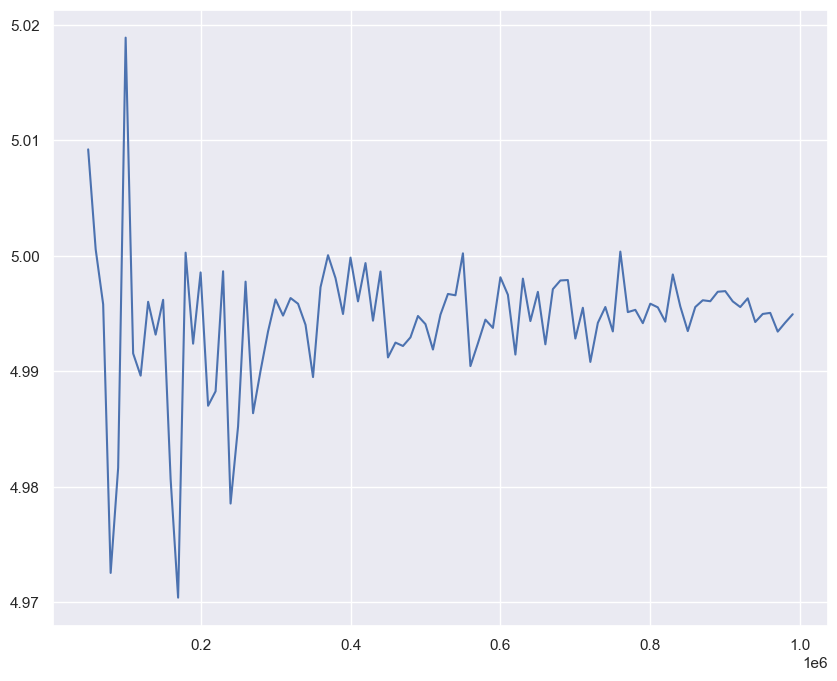

In [64]:
n, p, size = 100, 0.5, 10**6
pop = pd.DataFrame({'x': nr.binomial(n, p, size)}) # a large binomial distributed population
n_range = np.arange(1, 10**6, 10000) # different sample sizes we want to try this with
out = [pop.sample(n = x)['x'].std(axis = 0) for x in n_range] # means of samples of different sizes

print(pop['x'].std())
sns.lineplot(x = n_range[5:], y = out[5:]);

As we can see, the "ups and downs" get smaller and smaller as we move to the right, which corresponds to using larger samples to estimate the true population mean. So another way to interpret the law of large numbers is that it is not that uncommon to see large variations in small samples, but those variations begin to fade away with larger and larger samples. For example, if you toss a fair coin 4 times, an outcome consisting of only heads is not that uncommon, but if you toss the coin 20 times, such an outcome would be very rare. So with large samples, the ratio of heads to number of throws approaches $50\%$ more and more.

Here's another example involving the normal distribution. Let's first generate the data:

In [65]:
start = 10
end = 10000
step = 10

norms = pd.DataFrame(columns = ['n', 'mean', 'std'], dtype = np.float32)
     
for index, n in enumerate(range(start, end, step)):
    sample = nr.normal(loc = 0.0, scale = 1.0, size = n)
    norms.loc[index, ['n', 'mean', 'std']] = n, np.mean(sample), np.std(sample)

norms.head()

,n,mean,std
0,10.0,0.101663,0.452180
1,20.0,-0.428590,1.161024
2,30.0,0.018469,0.873155
3,40.0,-0.407427,1.005697
4,50.0,-0.046744,0.889005


Let's see how the mean of the sample converge to the population mean and the sample standard deviation converge to the population standard deviation:

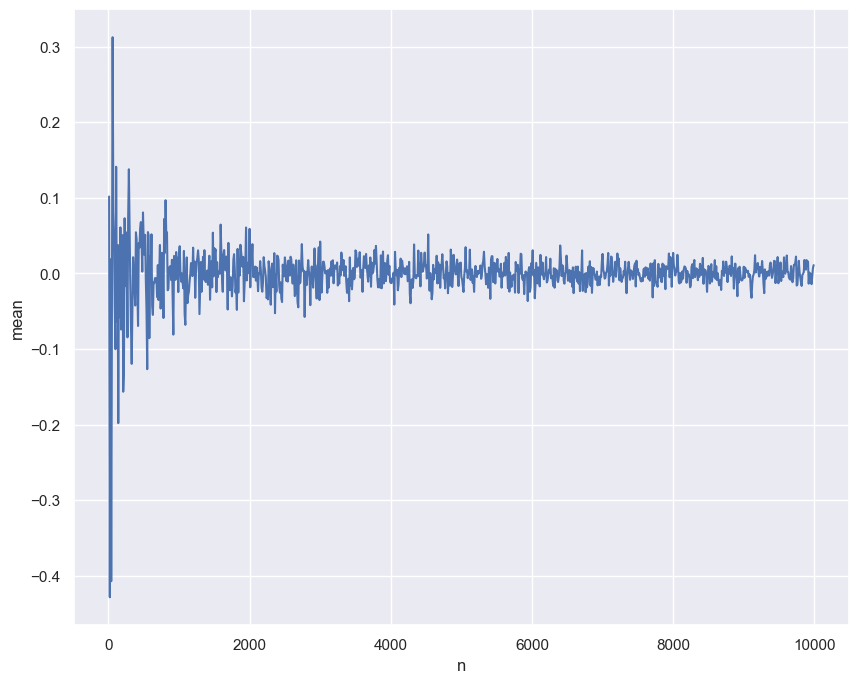

In [66]:
sns.lineplot(x = 'n', y = 'mean', data = norms);

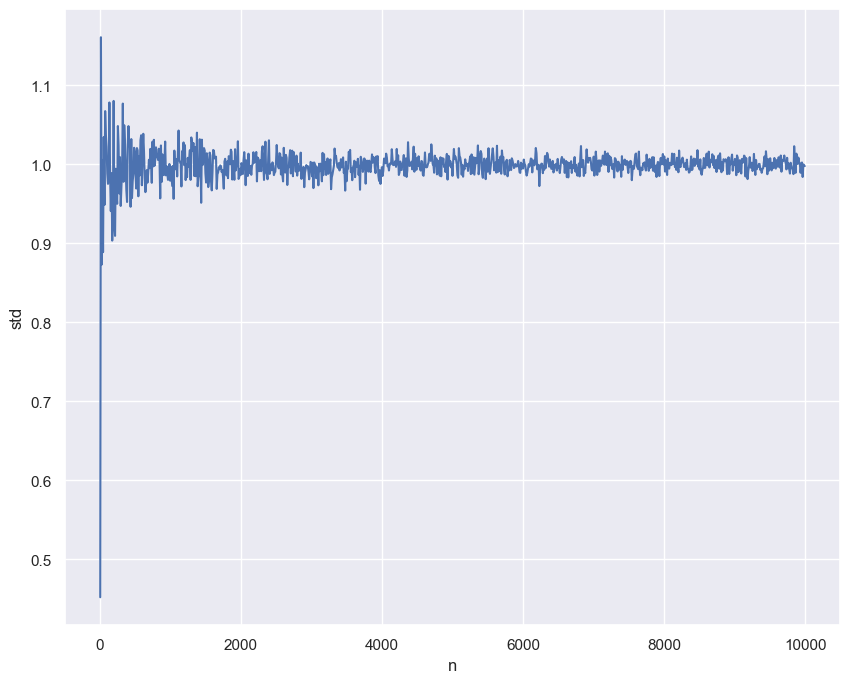

In [67]:
sns.lineplot(x = 'n', y = 'std', data = norms);

### Exercise



The law of large numbers should not be very surprising. After all, all it says is that as a sample gets bigger and bigger it resembles the population more and more. There is a another theorem in statistics with slightly more surprising results: The **central limit theorem (CLT)** states that if you draw samples from a population and take their average $\bar X$, then for a large enough sample size $n$, $\bar X$ is normally distributed with mean $\mu$ and standard deviation $\sigma/\sqrt n$ where $\mu$ and $\sigma$ are the populations mean and variance. In other words,

$$\text{if }\bar X = \sum_{i = 1}^n \frac{1}{n} X_i \text{ , then } \bar X \sim N(\mu, \frac{\sigma^2}{n}) \text{ for large enough } n$$

The surprising thing about the CLT is that it is true **regardless of the distribution of $X$ itself**. That means that $X$ can have any distribution (that look nothing like the normal distribution), but with $n$ large enough $\bar X$ will follow a normal distribution. This means we can use the normal distribution to quantify our uncertainty about $\bar X$ for a given sample size.

Check if this is true by generating 100 random samples of sizes $n = 25$ from an exponential distribution with $\beta = 2/3$, which we can write as $X \sim \text{Exp}(\beta)$ and finding the sample mean each time. NOTE: The theoretical (population) mean and variance of a exponential distribution are $\beta$ and $\beta^2$ respectively. So our goal is to show $\bar X \sim N(\beta, \beta^2 / \sqrt{n})$, which should look more and more so the larger $n$.

Plot the distribution of the $X$, then plot the distribution of $\bar X$. HINT: Use `sns.displot`.

In [ ]:
results = pd.DataFrame(columns=['size'])

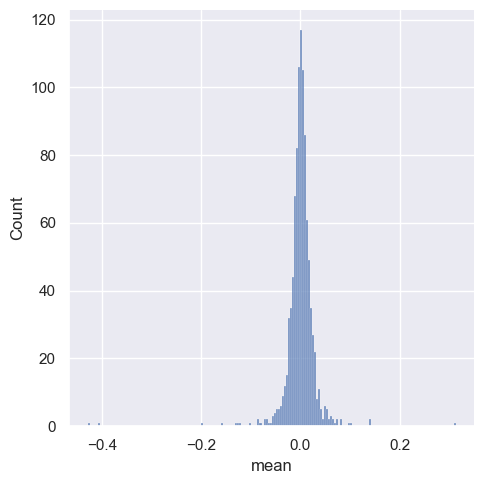

In [70]:
sns.displot(norms,x='mean');

### Exercise

# Assignment

We learned from the central limit theorem that the **mean** of a sample of size $n$ follows a normal distributon with center $\mu$ and variance $\sigma^2 / n$ where $\mu$ and $\sigma$ are the mean and variance of the population the sample was drawn from. And more importantly, the CTL holds **regardless of the distribution of the population** itelf as long as the sample size is large enough. So this leads to another question? What if we wanted to estimate the distribution of *some other statistic* besides the sample mean? For example, can we draw a similar conclusion about the distribution of the **sample median**? What about the distribution of the **sample variance**? Unfortunately, the CLT only applies to the sample mean, and finding the distribution of any other statistic is not that straight-forward. The CLT is like a mathematical guaratee, but we usually cannot make a similar guarantee with other statistics. So instead we can use computational methods to estimate the distribution of our statistic. One example of such computational method is **bootstrapping**.

The sampling techniques we learned in the lecture mainly deal with the problem of how to create smaller data in a way that it is representative of the larger population, and all of them were a form of sampling **without replacement**. **Bootstrapping** consists of **repeated sampling from data with replacement** (which means the same row of data can end of more than once in the sampled data). Bootstrapping is useful technique when we want to estimate the distribution of a statistic that would otherwise be hard to estimate.

Let's return to the bank marketing data from previous exercises:

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bank = pd.read_csv('../data/bank-full.csv', delimiter = ';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


- Report the difference in the average balance for single vs married individuals in the data. <span style="color:red" float:right>[1 point]</span>

In [23]:
## your code goes here

Since balance is skewed to the right, maybe it's not such a good idea to compare averages for these two groups. So instead of the average, let's use the **median**.

- Report the difference in the median balance for single vs married individuals in the data. How does this compare to using the mean? <span style="color:red" float:right>[1 point]</span>

In [24]:
## your code goes here

But what is the distribution of the above statistics?

- In the case of the mean, we could rely on the CLT to answer that, assuming that we know the mean and variance of balance for single and married individuals **in the population** (our data is the sample).
- In the case of the median, we cannot rely on the CLT, so we will use bootstrapping to estimate the distribution.

1. Take a bootstrap sample from the data. You can use the `sample` method to do this. Recall that a bootstrap sample is a sample **with replacement**. Your bootstrap sample should have the same size (number of rows) as the data. <span style="color:red" float:right>[5 point]</span>
1. Find the difference between the median bank balances for single vs. married individuals in the bootstrap sample. We will refer to this as the **bootstrap estimate**. <span style="color:red" float:right>[2 point]</span>
1. Repeat steps 1 and 2 over 1000 iterations, and at the end of each iteration store the bootstrap estimate into a list we call `bootstrap_estimates`. <span style="color:red" float:right>[2 point]</span>

In [25]:
bootstrap_estimates = []
n_iters = 1000

## your code goes here

- Display the distribution of the 1000 bootstrap estimates we found. Does the distribution of the difference in medians appear to be symmetric? <span style="color:red" float:right>[2 point]</span>

In [26]:
## your code goes here

- What is its standard deviations? <span style="color:red" float:right>[1 point]</span>

In [27]:
## your code goes here

So we now have not only the difference in median balance between the two groups, but we also have a measure of how uncertain this estimate is, based on bootrapping. 

# End of assignment